# ClarkFork River economic analysis using standard PMP

In this tutorial we explain the process of calibrating the economic component of the hydro-economic model using a standard positive mathematical programming (PMP) algorithm develop by [Howitt (1995)](https://pdfs.semanticscholar.org/852c/9b78d676886327ecf0b219227d7641f2cf0e.pdf). The calibration routines in our model implement the adaptation and improvements to PMP described in [Merel (2013)](https://doi.org/10.1093/ajae/aat053). 

PMP is designed to calibrate agroeconomic production models that simulate the economic behavior of producers at regional scales. The `econengine` module includes a `Farm` class that represents a regional aggregation of producers. The interface of this class has two main methods: `calibrate(**obs)` and `simulate(**scenario)`. Calibrating and simulating with this module consists in creating a `Farm` object and calling one these methods with the appropriate observation specification dictionary or scenario specification dictionary. 

In this example we will calibrate a model to simulate land and water allocation at the county scale for five counties in the Clark Fork River in western Montana. Once the necessary information is obtained and organized in the correct format, the calibration and simulation process consists simple and reduced to the following 4 steps:

1. Read the farm definition files
2. Read observations of agricultural activity 
3. Create a Farm object
4. Call the calibrate method for each Farm with the observations previously read
5. Save the calibrated farms for use during simulations
6. Use the calibrated farms for simulation of scenarios using a scenario definition file



In [15]:
# load standard packages
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

# load packages from DAWUAP
import utils
from econengine import econfuncs

## Reading the farm definition file

The first step is to read the farm definition file, which is a dictionary containing a `farm` key. This key holds a list of dictionaries containing information on the farms to be simulated. The dictionary is read as a json file. The [section on the farm definition dictionary](file.html) provides a description of the file format and the keys that should be in the dictionary. 

In [16]:
# __ Read and format the input data for the Clark Fork River example __

# open farm definition file; this file contains basic data for the 8
# counties within the CFR
with open('../ClarkForkTutorial/econ/Farms_ClarkFork.json') as json_farms:
    dct_farms = json.load(json_farms)
    


## Reading observations used for calibration

To calibrate using the standard positive mathematical programming (PMP) methodology we need observations of agricultural activity (land and water allocation), as well as information on crop prices and other ancillary economic information. This information is provided as a list of dictionaries (one dictionary per farm) containing  all the necessary information ([file format described here](hth.html)) to run the calibration step and adjust the parameters that define the farm economic behavior. 


In [17]:

# open observations files; this file contains observations for the 55
# counties of Montana
with open('../ClarkForkTutorial/econ/observations/Observations_ClarkFork2012.json') as json_obs:
    lst_obs_Montana = json.load(json_obs)

# select counties within the Clark Fork River and append them to a new dictionary
lst_obs = [o for f in dct_farms['farms'] for o in lst_obs_Montana if o['id'] == f['id']]


## Calibration using standard PMP

We're going to calibrate the unknown model parameters that represent the farm economic behavior. Recall that farm is actually an aggregation of producers at the county level. To calibrate the farms we will use the `calibrate()` method of the `Farm` class defined in the `econfuncs` package we imported earlier (class `Farm` within package `ecofuncs`).

With the standard PMP methodology calibration is based on observations from one representative year. In this tutorial we are going to use observations from year 2012. For multi-year operational calibration we provide a [recursive Bayesian calibration](html.html) approach.

In [18]:
# __ Calibrate the counties (`farms`) and save it __

# create a dictionary with a new key (`farms`) an empty list to store the results
calibrated_farms = {'farms': []}

# calibration loop; on this loop we generate objects `res`, which contains
# farms calibrated
for f in dct_farms['farms']: # LOOPING THROUGH EACH FARM IN THE FARM DICTIONARY
    print 'Calibrating farm', f['name']
    farm_farm = econfuncs.Farm(**f)
    obs = [o for o in lst_obs if o['id'] == farm_farm.id] # READ OBSERVATIONS FOR CURRENT FARM
    res = farm_farm.calibrate(**obs[0]) # <-- KEY CALIBRATE() METHOD
    if res.success:
        calibrated_farms['farms'].append(farm_farm.write_farm_dict())
        
# save calibrated farms under name 'calibrated_Farms_ClarkFork.json'
with open('../ClarkForkTutorial/econ/calibrated_Farms_ClarkFork.json', 'w') as json_farms_out:
    json.dump(calibrated_farms, json_farms_out)

Calibrating farm Deer Lodge
Farm Deer Lodge with id 30023 successfully calibrated
Calibrating farm Granite
Farm Granite with id 30039 successfully calibrated
Calibrating farm Lewis And Clark
Farm Lewis And Clark with id 30049 successfully calibrated
Calibrating farm Mineral
Farm Mineral with id 30061 successfully calibrated
Calibrating farm Missoula
Farm Missoula with id 30063 successfully calibrated
Calibrating farm Powell
Farm Powell with id 30077 successfully calibrated
Calibrating farm Ravalli
Farm Ravalli with id 30081 successfully calibrated
Calibrating farm Silver Bow


THIS IS IT! the last two lines in the previous code save the farm definitions but now the parameters are calibrated based on the observations provided to the `calibrate` method. These farms can now be used to simulate scenarios. 

# Simulate a baseline scenario

Simulation of scenarios is possible by manipulating the inputs in a [scenario definition file](html.html). This file provide information about the conditions (policy, market and environmental stressors) that farmers experience and determine how they allocate resources. 

We are going to build a scenario definition file with the same conditions observed for year 2012. For convenience we we will create a function to generate the scenario dictionaries with information from the 2012 observations.  We will use this scenario definition to run a baseline simulation and evaluate if the model is correctly calibrated and reproduces the resource allocation observed during 2012. 


In [56]:
# __ Generate scenarios __

# a function to generate custom scenarios; the function takes two arguments:
# a dictionary with the observations (`obs`) and the year of the observations
# (`year`).
def generate_scenario(obs, year):
    # generate a dictionary to contain the scenario definion
    env = {
        'farm_id': obs['id'],
        'year': year,
        'evapotranspiration': (np.array(obs['obs_water'])*0.8).tolist(),
        'prices': obs['prices'],
        'costs': obs['costs'],
        'land_constraint': np.sum(obs['obs_land']).tolist(),
        'water_constraint': (np.sum(obs['obs_water'])*0.1).tolist(),
        'crop_start_date': ["5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year),
            "5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year),"5/15/"+str(year), "5/15/"+str(year)],
        'crop_cover_date': ["7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year),
            "7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year),"7/02/"+str(year), "7/02/"+str(year)],
        'crop_end_date': ["8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year),
            "8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year),"8/25/"+str(year), "8/25/"+str(year)], 
    }
    return(env)

# create an empty list to store the scenarios (there'd be one scenario per farm)
lst_scenarios = []

# fill in the previous object with scenarios for each farm, using information
# from obs (created in the previous code chunk) and the generator function we just defined
for o in lst_obs:
    lst_scenarios.append(generate_scenario(o, 2012))

# save the baseline scenario under name 'baseline_scenario.json' 
with open('../ClarkForkTutorial/econ/scenarios/baseline_scenario.json', 'w') as sce:
     json.dump(lst_scenarios, sce)
        

In [57]:
# __ Simulate scenarios __

# load the calibrated farms file into `dct_farms_calibrated`
with open('../ClarkForkTutorial/econ/calibrated_Farms_ClarkFork.json', 'r') as json_farms_calibrated:
    dct_farms_calibrated = json.load(json_farms_calibrated)

# create a dictionary with a new key (`farms`) an empty list to store the results
simulated_farms = {'farms': []}
    
# a loop to simulate each county ('farm')
for f in dct_farms_calibrated['farms']: # RUN A LOOP THROUGH THE CALIBRATED FARMS DICTIONARY
    print 'Simulating farm', f['name']
    farm_farm = econfuncs.Farm(**f)
    scen = [o for o in lst_scenarios if o['farm_id'] == farm_farm.id]
    res = farm_farm.simulate(**scen[0]) # <-- KEY SIMULATE() METHOD
    if res.success:
        simulated_farms['farms'].append(farm_farm.write_farm_dict())

# save simulated farms
with open('../ClarkForkTutorial/econ/baseline_simulations.json', 'w') as json_farms_out:
    json.dump(simulated_farms, json_farms_out)

Simulating farm Deer Lodge
Simulating farm Granite
Simulating farm Lewis And Clark
Simulating farm Mineral
Simulating farm Missoula
Simulating farm Powell
Simulating farm Ravalli


## Inspecting simulation results

The results of a simulation are written to the `simulated states` key of the simulated farms files. This key can easily be extracted and read into a pandas dataframe for further analysis and inspection.  

In [58]:
# __ Inspect the results of simulation __

# load simulated farms
with open('../ClarkForkTutorial/econ/baseline_simulations.json', 'r') as kk:
    dict_farms_simulation_baseline = json.load(kk)

# extract the data for the first farm (and store into a data frame, df)
df_farms_simulation_baseline = pd.DataFrame(dict_farms_simulation_baseline['farms'][0]['simulated_states'])
df_farms_simulation_baseline.index = dict_farms_simulation_baseline['farms'][0]['crop_list']


Text(0.5,1,'Observed vs simulated land allocation')

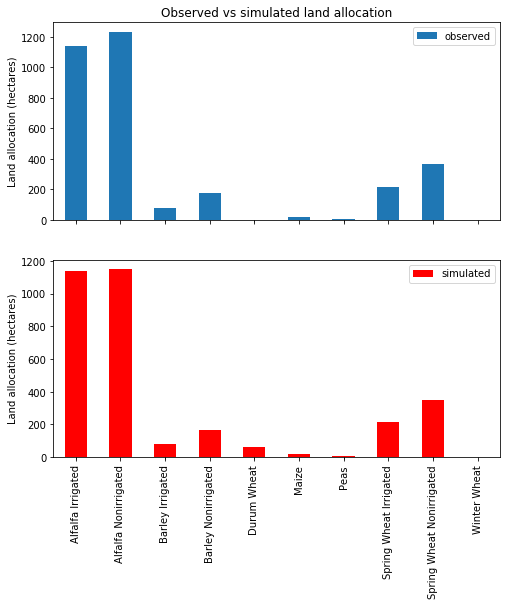

In [60]:
# plot simulated land per crop and compare with observations
# compare with the observed used land 
df_farms_observed = pd.DataFrame(lst_obs[0])

fig, ax = plt.subplots(2,1, sharex=True, squeeze=True,figsize=(8,8) )
df_farms_observed['obs_land'].plot('bar', ax=ax[0], label='observed')
df_farms_simulation_baseline['used_land'].plot('bar', ax=ax[1], color='r', label='simulated')
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Land allocation (hectares)')
ax[1].set_ylabel('Land allocation (hectares)')
ax[1].legend()
ax[0].set_title('Observed vs simulated land allocation')


## Simulate a meteorological drought scenario

We are going to make a simulation now with different conditions. For instance, we shall simulate a severe drought in which precipitation is reduced to 50% of the baseline. The water for irrigation is not constrained on this scenario. Therefore, it is a climatic drought scenario.

This could be easily done by editing the `baseline_scenarios.json` file, but we will follow the same approach used before and create a new simulation file.

In [12]:
# __ Generate scenarios __

# a function to generate custom scenarios; we add a parameter `dr_factor`,
# which represents the fraction of precipitation reduction.
def generate_drought_scenario(obs, year, dr_factor):
    env = {
        'farm_id': obs['id'],
        'year': year,
        'evapotranspiration': (np.array(obs['obs_water'])*dr_factor).tolist(),
        'prices': obs['prices'],
        'costs': obs['costs'],
        'land_constraint': np.sum(obs['obs_land']).tolist(),
        'water_constraint': -1, #np.sum(obs['obs_water']),
        'crop_start_date': ["5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year),
            "5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year),"5/15/"+str(year), "5/15/"+str(year)],
        'crop_cover_date': ["7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year),
            "7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year),"7/02/"+str(year), "7/02/"+str(year)],
        'crop_end_date': ["8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year),
            "8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year),"8/25/"+str(year), "8/25/"+str(year)], 
    }
    return(env)

# create an empty list to store the scenarios (there'd be one scenario per farm)
lst_scenarios = []

# fill in the previous object with scenarios for each farm, using information
# from obs (created in the previous code chunk) and the generator function we just defined
for o in lst_obs:
    lst_scenarios.append(generate_drought_scenario(o, 2012, 0.5))

# save the scenarios
with open('../data/scenarios/scenarios/drought_scenarios.json', 'w') as kk:
     json.dump(lst_scenarios, kk)

IOError: [Errno 2] No such file or directory: '../data/scenarios/drought_scenarios.json'

In [62]:
# __ Simulate scenarios __

# load the calibrated farms file into `dct_farms_calibrated`
with open('../data/EconParams/calibrated_Farms_ClarkFork.json', 'r') as json_farms_calibrated:
    dct_farms_calibrated = json.load(json_farms_calibrated)

# create a dictionary with a new key (`farms`) an empty list to store the results
simulated_farms = {'farms': []}
    
# a loop to simulate each county ('farm')
for f in dct_farms_calibrated['farms']:
    print 'Simulating farm', f['name']
    farm_farm = econfuncs.Farm(**f)
    scen = [o for o in lst_scenarios if o['farm_id'] == farm_farm.id]
    res = farm_farm.simulate(**scen[0]) # ?simulate
    if res.success:
        simulated_farms['farms'].append(farm_farm.write_farm_dict())

# save simulated farms
with open('../data/scenarios/drought_simulations.json', 'w') as json_farms_out:
    json.dump(simulated_farms, json_farms_out)

Simulating farm Deer Lodge
Simulating farm Granite
Simulating farm Lewis And Clark
Simulating farm Mineral
Simulating farm Missoula
Simulating farm Powell
Simulating farm Ravalli
Simulating farm Silver Bow


In [63]:
# __ Inspect the results of simulation __

# load simulated farms
with open('../data/scenarios/drought_simulations.json', 'r') as kk:
    dct_farms_simulation_drought = json.load(kk)

# extract the data for the first farm (and store into a data frame, df)
df_farms_simulation_drought = pd.DataFrame(dct_farms_simulation_drought['farms'][0]['simulated_states'])
df_farms_simulation_drought.index = dct_farms_simulation_drought['farms'][0]['crop_list']

df_farms_simulation_drought

net_revenues  shadow_price_land  \
Alfalfa Irrigated             -0.535279       8.476478e-12   
Alfalfa Nonirrigated           1.724016       8.476478e-12   
Barley Irrigated               0.047184       4.039735e-13   
Barley Nonirrigated            0.100507       4.039735e-13   
Durum Wheat                   -0.175051       6.239386e-13   
Maize                          0.015525       3.867370e-13   
Peas                           0.005357       9.399357e-13   
Spring Wheat Irrigated         0.211209       5.433697e-13   
Spring Wheat Nonirrigated      0.475225       5.433697e-13   
Winter Wheat                   0.002741       4.893699e-13   

                           shadow_price_water  supply_elasticity_eta  \
Alfalfa Irrigated               -6.879150e-09                   0.35   
Alfalfa Nonirrigated            -6.879150e-09                   0.29   
Barley Irrigated                -3.278477e-10                   0.29   
Barley Nonirrigated             -3.278477e-10                   1.33   
Durum Wheat                     -5.063621e-10                   0.38   
Maize                           -3.138593e-10                   0.38   
Peas                            -7.628119e-10                   0.35   
Spring Wheat Irrigated          -4.409758e-10                   0.35   
Spring Wheat Nonirrigated       -4.409758e-10                   0.35   
Winter Wheat                    -3.971518e-10                   0.29   

                             used_land    used_water  yield_elasticity_water  \
Alfalfa Irrigated          1139.901300  4.490616e+02                    0.06   
Alfalfa Nonirrigated        975.320149  1.409887e-15                    0.21   
Barley Irrigated             79.638869  4.470105e+02                    0.21   
Barley Nonirrigated         142.870271  8.222042e-16                    0.26   
Durum Wheat                 169.140057  4.739442e-15                    0.06   
Maize                        17.286686 -1.040467e-15                    0.06   
Peas                          5.752633  3.038444e-15                    0.06   
Spring Wheat Irrigated      212.810730  4.458252e+02                    0.06   
Spring Wheat Nonirrigated   301.038677  2.028895e-15                    0.06   
Winter Wheat                  2.237336 -1.416884e-14                    0.21   

                                 yields  
Alfalfa Irrigated          1.073855e+00  
Alfalfa Nonirrigated       3.268520e-01  
Barley Irrigated           3.674928e+00  
Barley Nonirrigated        2.930543e+00  
Durum Wheat                2.364493e-24  
Maize                      4.720490e-01  
Peas                       3.265612e-02  
Spring Wheat Irrigated     4.577088e+00  
Spring Wheat Nonirrigated  3.088051e+00  
Winter Wheat               4.405509e-02

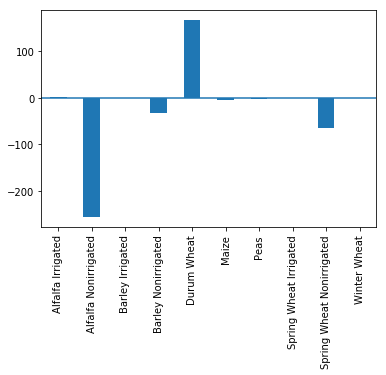

In [64]:
# absolute change of land allocated per crop
(df_farms_simulation_drought['used_land'] - df_farms_simulation_baseline['used_land']).plot('bar')
plt.axhline(0)



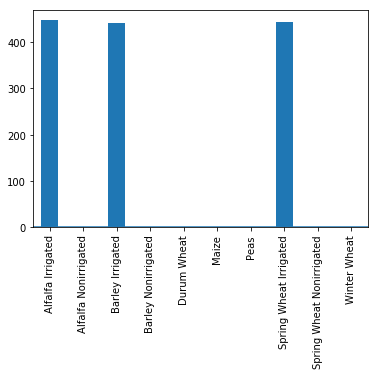

In [65]:
# absolute change of water allocated per crop
plt.Figure()
(df_farms_simulation_drought['used_water'] - df_farms_simulation_baseline['used_water']).plot('bar')
plt.axhline(0)

## Simulate a hydrological drought scenario

We are going to make a simulation in which there is no shortage of precipitation, but the irrigation water available is reduced to 50% of the baseline.

We will set `evapotranspiration` to 0.1 for the crop that are irrigated, because we assume that 10% of the crop needs are fed by rainfall; but we will leave it to 1 for rainfed crops, since we are simulating that there is no shortage of rainfall on that year. The mask variable (`irrigtation_mask`) shall come in handy for this.

For simulating a shortage in irrigation water we will use the `water_constraint` parameter. This is a tricky parameter now, because it is expressed in mm but in fact it is a sum of volumes. On the baseline scenario, the total water used in irrigated crops sums to 2755 mm (but this does not mean that the average use is 2755 mm, it is a sum... puzzling, I know, but Marco is into it). We will reduce this quantity by 50%.

In [13]:
# __ Generate scenarios __

# we generate a vector with the evapotranspiration constraints
kk = np.array(obs[0]['obs_water'])
kk[farm_farm.irr] *= 0.1
#print(kk)

# a function to generate custom scenarios; we add a parameter `dr_factor`,
# which represents the fraction of precipitation reduction.
def generate_hydro_drought_scenario(obs, year, dr_factor):
    env = {
        'farm_id': obs['id'],
        'year': year,
        'evapotranspiration': kk.tolist(),
        'prices': obs['prices'],
        'costs': obs['costs'],
        'land_constraint': np.sum(obs['obs_land']).tolist(),
        'water_constraint': 2755 * dr_factor,
        'crop_start_date': ["5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year),
            "5/15/"+str(year), "5/15/"+str(year), "5/15/"+str(year),"5/15/"+str(year), "5/15/"+str(year)],
        'crop_cover_date': ["7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year),
            "7/02/"+str(year), "7/02/"+str(year), "7/02/"+str(year),"7/02/"+str(year), "7/02/"+str(year)],
        'crop_end_date': ["8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year),
            "8/25/"+str(year), "8/25/"+str(year), "8/25/"+str(year),"8/25/"+str(year), "8/25/"+str(year)], 
    }
    return(env)

# create an empty list to store the scenarios (there'd be one scenario per farm)
lst_scenarios = []

# fill in the previous object with scenarios for each farm, using information
# from obs (created in the previous code chunk) and the generator function we just defined
for o in lst_obs:
    lst_scenarios.append(generate_hydro_drought_scenario(o, 2012, 0.5))

# save the scenarios
with open('../data/scenarios/scenarios/hydro_drought_scenarios.json', 'w') as kk:
     json.dump(lst_scenarios, kk)

IOError: [Errno 2] No such file or directory: '../data/scenarios/scenarios/hydro_drought_scenarios.json'

In [67]:
# __ Simulate scenarios __

# load the calibrated farms file into `dct_farms_calibrated`
with open('../data/EconParams/calibrated_Farms_ClarkFork.json', 'r') as json_farms_calibrated:
    dct_farms_calibrated = json.load(json_farms_calibrated)

# create a dictionary with a new key (`farms`) an empty list to store the results
simulated_farms = {'farms': []}
    
# a loop to simulate each county ('farm')
for f in dct_farms_calibrated['farms']:
    print 'Simulating farm', f['name']
    farm_farm = econfuncs.Farm(**f)
    scen = [o for o in lst_scenarios if o['farm_id'] == farm_farm.id]
    res = farm_farm.simulate(**scen[0]) # ?simulate
    if res.success:
        simulated_farms['farms'].append(farm_farm.write_farm_dict())

# save simulated farms
with open('../data/scenarios/hydro_drought_simulations.json', 'w') as json_farms_out:
    json.dump(simulated_farms, json_farms_out)

Simulating farm Deer Lodge
Simulating farm Granite
Simulating farm Lewis And Clark
Simulating farm Mineral
Simulating farm Missoula
Simulating farm Powell
Simulating farm Ravalli
Simulating farm Silver Bow


In [68]:
# __ Inspect the results of simulation __

# load simulated farms
with open('../data/scenarios/hydro_drought_simulations.json', 'r') as kk:
    dct_farms_simulation_drought = json.load(kk)

# extract the data for the first farm (and store into a data frame, df)
df_farms_simulation_drought = pd.DataFrame(dct_farms_simulation_drought['farms'][0]['simulated_states'])
df_farms_simulation_drought.index = dct_farms_simulation_drought['farms'][0]['crop_list']

df_farms_simulation_drought

net_revenues  shadow_price_land  \
Alfalfa Irrigated             -0.304542       2.896158e-10   
Alfalfa Nonirrigated          -0.906789       2.896158e-10   
Barley Irrigated               0.054367       1.380256e-11   
Barley Nonirrigated            0.088083       1.380256e-11   
Durum Wheat                   -0.023074       2.131811e-11   
Maize                          0.014362       1.321364e-11   
Peas                           0.004465       3.211478e-11   
Spring Wheat Irrigated         0.218534       1.856531e-11   
Spring Wheat Nonirrigated      0.452535       1.856531e-11   
Winter Wheat                   0.002514       1.672030e-11   

                           shadow_price_water  supply_elasticity_eta  \
Alfalfa Irrigated                    0.000574                   0.35   
Alfalfa Nonirrigated                 0.000574                   0.29   
Barley Irrigated                     0.000027                   0.29   
Barley Nonirrigated                  0.000027                   1.33   
Durum Wheat                          0.000042                   0.38   
Maize                                0.000026                   0.38   
Peas                                 0.000064                   0.35   
Spring Wheat Irrigated               0.000037                   0.35   
Spring Wheat Nonirrigated            0.000037                   0.35   
Winter Wheat                         0.000033                   0.29   

                             used_land    used_water  yield_elasticity_water  \
Alfalfa Irrigated          1078.282227  6.595821e+02                    0.06   
Alfalfa Nonirrigated       1258.662442  2.301366e-16                    0.21   
Barley Irrigated             58.758688  2.436563e+02                    0.21   
Barley Nonirrigated         180.931728  1.274191e-15                    0.26   
Durum Wheat                  22.295077  9.789862e-16                    0.06   
Maize                        21.928939 -7.344938e-16                    0.06   
Peas                          7.684946 -2.389380e-16                    0.06   
Spring Wheat Irrigated      187.689708  4.741864e+02                    0.06   
Spring Wheat Nonirrigated   388.192181 -6.426870e-16                    0.06   
Winter Wheat                  2.965637 -3.829613e-16                    0.21   

                                 yields  
Alfalfa Irrigated          1.045873e+00  
Alfalfa Nonirrigated       3.704403e-01  
Barley Irrigated           3.238849e+00  
Barley Nonirrigated        3.236849e+00  
Durum Wheat                2.364493e-24  
Maize                      5.229038e-01  
Peas                       4.030135e-02  
Spring Wheat Irrigated     4.330921e+00  
Spring Wheat Nonirrigated  3.458166e+00  
Winter Wheat               4.946659e-02

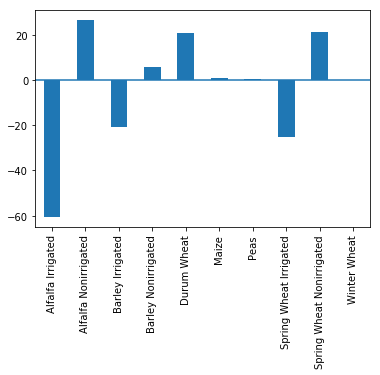

In [69]:
# absolute change of land allocated per crop
(df_farms_simulation_drought['used_land'] - df_farms_simulation_baseline['used_land']).plot('bar')
plt.axhline(0)



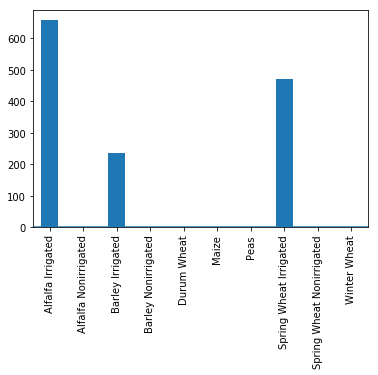

In [70]:
# absolute change of water allocated per crop
plt.Figure()
(df_farms_simulation_drought['used_water'] - df_farms_simulation_baseline['used_water']).plot('bar')
plt.axhline(0)